<a href="https://colab.research.google.com/github/KenMuriuki/NYC_taxi_prediction/blob/main/taxi_demandNYC_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **New York Yellow Taxi Demand Project**

This project aims to predict taxi demand in Manhattan, New York City. It will utilize the Prophet module to create a predictive model that to forecast the number of taxi rides that will happen in Manhattan: -
- Per hour
- Per zone

in the following three days.

The following are the steps used to implement this model.
1. Obtaining & reading the historical data on the taxi rides.
2. Pre-processing the data into a time series format. This will involve:-
    - Aggregating the number of rides based on the hour and location of pick-up.
    - This should result in a 3-column dataset. pickup time ro the nearest hour, pick up location, and number of rides.
3. Train a predictive model using the Prophet module.

In [67]:
# importing the neccesary modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter 
from prophet import Prophet


In [9]:
# importing the necessary packages that are needed to read a parquet data file
 
!pip3 install pyarrow
!pip3 install snappy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.5/342.5 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 KB 8.3 MB/s eta 0:00:00


In [10]:
# reading the yellow taxis pick-up data for October, 2022 which is in parquet format.
df = pd.read_parquet('yellow_tripdata_2022-10.parquet', engine="pyarrow")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-10-01 00:03:41,2022-10-01 00:18:39,1.0,1.70,1.0,N,249,107,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,0.0
1,2,2022-10-01 00:14:30,2022-10-01 00:19:48,2.0,0.72,1.0,N,151,238,2,5.5,0.5,0.5,0.00,0.0,0.3,9.30,2.5,0.0
2,2,2022-10-01 00:27:13,2022-10-01 00:37:41,1.0,1.74,1.0,N,238,166,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0.0,0.0
3,1,2022-10-01 00:32:53,2022-10-01 00:38:55,0.0,1.30,1.0,N,142,239,1,6.5,3.0,0.5,2.05,0.0,0.3,12.35,2.5,0.0
4,1,2022-10-01 00:44:55,2022-10-01 00:50:21,0.0,1.00,1.0,N,238,166,1,6.0,0.5,0.5,1.80,0.0,0.3,9.10,0.0,0.0


In [11]:
# checking the dataset
print(df.info())

print('**************************************************************')

# checking for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3675411 entries, 0 to 3675410
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

I will ignore the mossing data since I will not be utilizing the particular columns. However the data has a few misclassified data points from years 2008 and 2009 and also from month of November. Therefore I will subset the data that I need.

In [12]:
# subsetting the october. 2022 data
df_oct = df[(df['tpep_pickup_datetime'].dt.month ==10) & (df['tpep_pickup_datetime'].dt.year ==2022)]
df_oct.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-10-01 00:03:41,2022-10-01 00:18:39,1.0,1.70,1.0,N,249,107,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,0.0
1,2,2022-10-01 00:14:30,2022-10-01 00:19:48,2.0,0.72,1.0,N,151,238,2,5.5,0.5,0.5,0.00,0.0,0.3,9.30,2.5,0.0
2,2,2022-10-01 00:27:13,2022-10-01 00:37:41,1.0,1.74,1.0,N,238,166,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0.0,0.0
3,1,2022-10-01 00:32:53,2022-10-01 00:38:55,0.0,1.30,1.0,N,142,239,1,6.5,3.0,0.5,2.05,0.0,0.3,12.35,2.5,0.0
4,1,2022-10-01 00:44:55,2022-10-01 00:50:21,0.0,1.00,1.0,N,238,166,1,6.0,0.5,0.5,1.80,0.0,0.3,9.10,0.0,0.0


In [19]:
#checking the shape of the dataset
df_oct.shape

(3675320, 20)

In [21]:
# rounding the pick-up date to nearest hour
df_oct['pickup_hour'] = df_oct['tpep_pickup_datetime'].round("H")
df_oct.head()

<ipython-input-21-e3bb4b9baf2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oct['pickup_hour'] = df_oct['tpep_pickup_datetime'].round("H")


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,1,2022-10-01 00:03:41,2022-10-01 00:18:39,1.0,1.70,1.0,N,249,107,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,0.0,2022-10-01 00:00:00
1,2,2022-10-01 00:14:30,2022-10-01 00:19:48,2.0,0.72,1.0,N,151,238,2,5.5,0.5,0.5,0.00,0.0,0.3,9.30,2.5,0.0,2022-10-01 00:00:00
2,2,2022-10-01 00:27:13,2022-10-01 00:37:41,1.0,1.74,1.0,N,238,166,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0.0,0.0,2022-10-01 00:00:00
3,1,2022-10-01 00:32:53,2022-10-01 00:38:55,0.0,1.30,1.0,N,142,239,1,6.5,3.0,0.5,2.05,0.0,0.3,12.35,2.5,0.0,2022-10-01 01:00:00
4,1,2022-10-01 00:44:55,2022-10-01 00:50:21,0.0,1.00,1.0,N,238,166,1,6.0,0.5,0.5,1.80,0.0,0.3,9.10,0.0,0.0,2022-10-01 01:00:00


As a result of rounding off to the nearest hour, data that was recorded last half hour of October 31 was recorded as November data. I opted to remove the data in order to achieve my objective. 

In [30]:
oct = df_oct[df_oct['pickup_hour'].dt.month ==10]
oct

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,1,2022-10-01 00:03:41,2022-10-01 00:18:39,1.0,1.70,1.0,N,249,107,1,9.50,3.0,0.5,2.65,0.0,0.3,15.95,2.5,0.0,2022-10-01 00:00:00
1,2,2022-10-01 00:14:30,2022-10-01 00:19:48,2.0,0.72,1.0,N,151,238,2,5.50,0.5,0.5,0.00,0.0,0.3,9.30,2.5,0.0,2022-10-01 00:00:00
2,2,2022-10-01 00:27:13,2022-10-01 00:37:41,1.0,1.74,1.0,N,238,166,1,9.00,0.5,0.5,2.06,0.0,0.3,12.36,0.0,0.0,2022-10-01 00:00:00
3,1,2022-10-01 00:32:53,2022-10-01 00:38:55,0.0,1.30,1.0,N,142,239,1,6.50,3.0,0.5,2.05,0.0,0.3,12.35,2.5,0.0,2022-10-01 01:00:00
4,1,2022-10-01 00:44:55,2022-10-01 00:50:21,0.0,1.00,1.0,N,238,166,1,6.00,0.5,0.5,1.80,0.0,0.3,9.10,0.0,0.0,2022-10-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675403,2,2022-10-31 23:15:00,2022-10-31 23:20:00,NaN,0.72,NaN,None,142,142,0,9.95,0.0,0.5,2.92,0.0,0.3,16.17,NaN,NaN,2022-10-31 23:00:00
3675404,1,2022-10-31 23:20:21,2022-10-31 23:34:15,NaN,2.70,NaN,None,163,68,0,12.00,0.5,0.5,3.95,0.0,0.3,19.75,NaN,NaN,2022-10-31 23:00:00
3675407,2,2022-10-31 23:22:00,2022-10-31 23:28:00,NaN,1.22,NaN,None,142,161,0,10.00,0.0,0.5,1.00,0.0,0.3,14.30,NaN,NaN,2022-10-31 23:00:00
3675408,2,2022-10-31 23:25:00,2022-10-31 23:48:00,NaN,4.70,NaN,None,186,45,0,19.07,0.0,0.5,4.97,0.0,0.3,27.34,NaN,NaN,2022-10-31 23:00:00


In [95]:
# aggregating the number of rides based on hour and then pickup location.

df_new = oct.groupby([oct['pickup_hour'], oct.PULocationID]).size().reset_index(name="counts")
df_new

# 

,pickup_hour,PULocationID,counts
0,2022-10-01 00:00:00,4,19
1,2022-10-01 00:00:00,7,2
2,2022-10-01 00:00:00,10,1
3,2022-10-01 00:00:00,13,7
4,2022-10-01 00:00:00,23,1
...,...,...,...
76108,2022-10-31 23:00:00,261,12
76109,2022-10-31 23:00:00,262,12
76110,2022-10-31 23:00:00,263,62
76111,2022-10-31 23:00:00,264,78


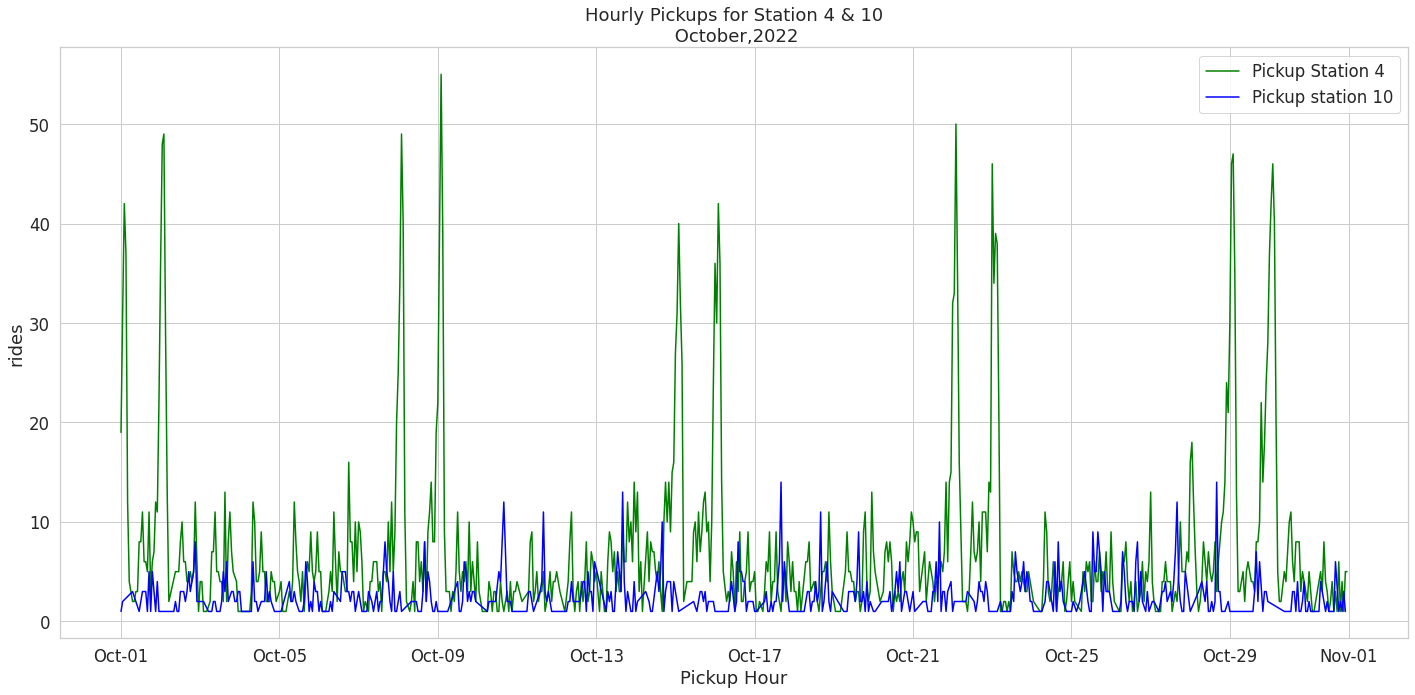

In [96]:
# data for two peak locations of interest (4 & 10)
loc_4 = df_new[df_new['PULocationID'] == 4]
loc_10 = df_new[df_new['PULocationID'] == 10]


# plotting the time series graph
sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(
    loc_4['pickup_hour'],
    loc_4['counts'],
    label='Pickup Station 4',
    color='green'
)
ax.plot(
    loc_10['pickup_hour'],
    loc_10['counts'],
    label='Pickup station 10',
    color='blue'
)
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter("%b-%d"))
ax.set(
    xlabel='Pickup Hour',
    ylabel="rides",
    title='Hourly Pickups for Station 4 & 10\n October,2022'
)
plt.tight_layout()
plt.show()

The time series graph above shows the number of rides taken from two locations by hour. The data shows that there are peak and off peak hours with station 4 being the busisest station.


## **Forecasting the number of hourly rides for station 4 the next month using Facebook's Prophet predictive model.**

In [97]:
# formatting the dataset for input into the model
loc_4 = loc_4.drop('PULocationID',axis=1)
loc_4.rename(
    columns={'pickup_hour':'ds','counts':'y'},
    inplace=True
)

In [98]:
# creating a model instance
model = Prophet()

# fitting the model to the dataset
model.fit(loc_4)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxr_rljf/812m3mml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxr_rljf/53yjnf_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92777', 'data', 'file=/tmp/tmpqxr_rljf/812m3mml.json', 'init=/tmp/tmpqxr_rljf/53yjnf_v.json', 'output', 'file=/tmp/tmpqxr_rljf/prophet_modelgzzdec2i/prophet_model-20230106203453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [102]:
# making future dataframe to predict November data for station 4. Prediction will be for 3 days.
future = model.make_future_dataframe(periods=72, freq='H')
future.tail()

,ds
740,2022-11-03 19:00:00
741,2022-11-03 20:00:00
742,2022-11-03 21:00:00
743,2022-11-03 22:00:00
744,2022-11-03 23:00:00


In [103]:
# forecasting the data by passing the dates to the model
counts_forecast = model.predict(future)

counts_forecast[["ds",'yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
740,2022-11-03 19:00:00,5.948805,-1.969709,14.021310
741,2022-11-03 20:00:00,5.918736,-2.326809,14.060000
742,2022-11-03 21:00:00,5.194645,-3.086250,13.611380
743,2022-11-03 22:00:00,5.588181,-2.876047,14.497119
744,2022-11-03 23:00:00,8.506649,0.290832,16.675136


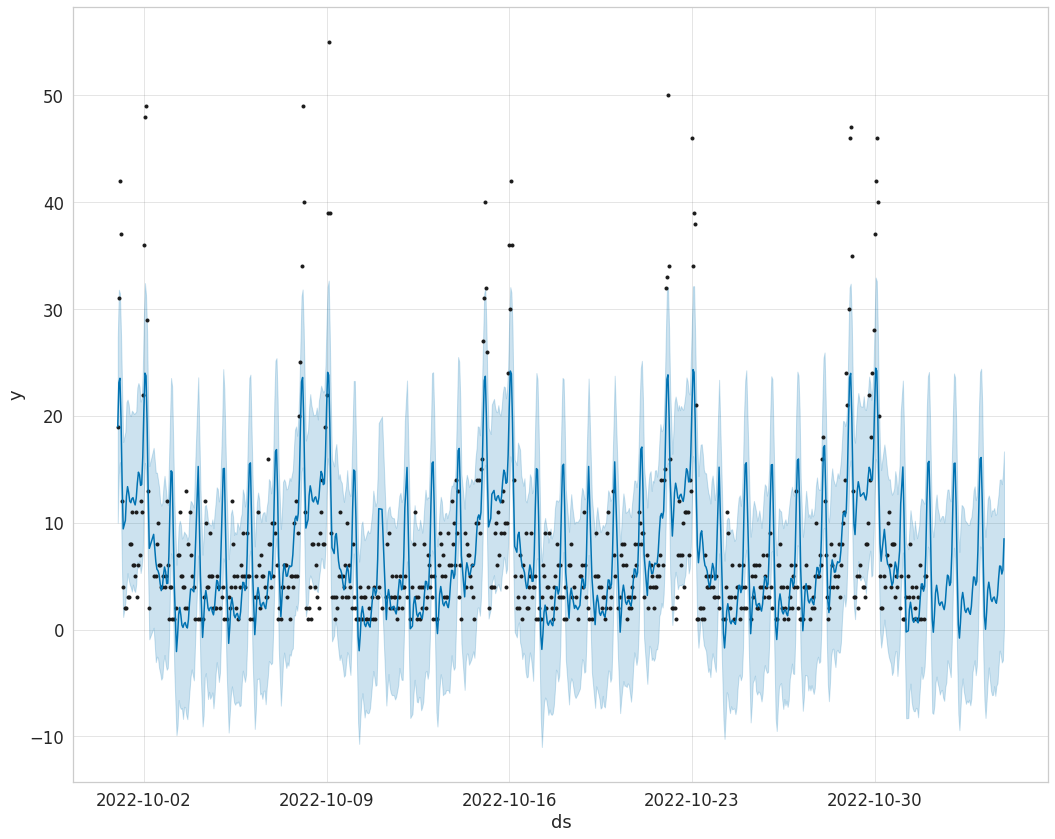

In [107]:
# plotting the forecasted values
plot = model.plot(counts_forecast, figsize=(15, 12))

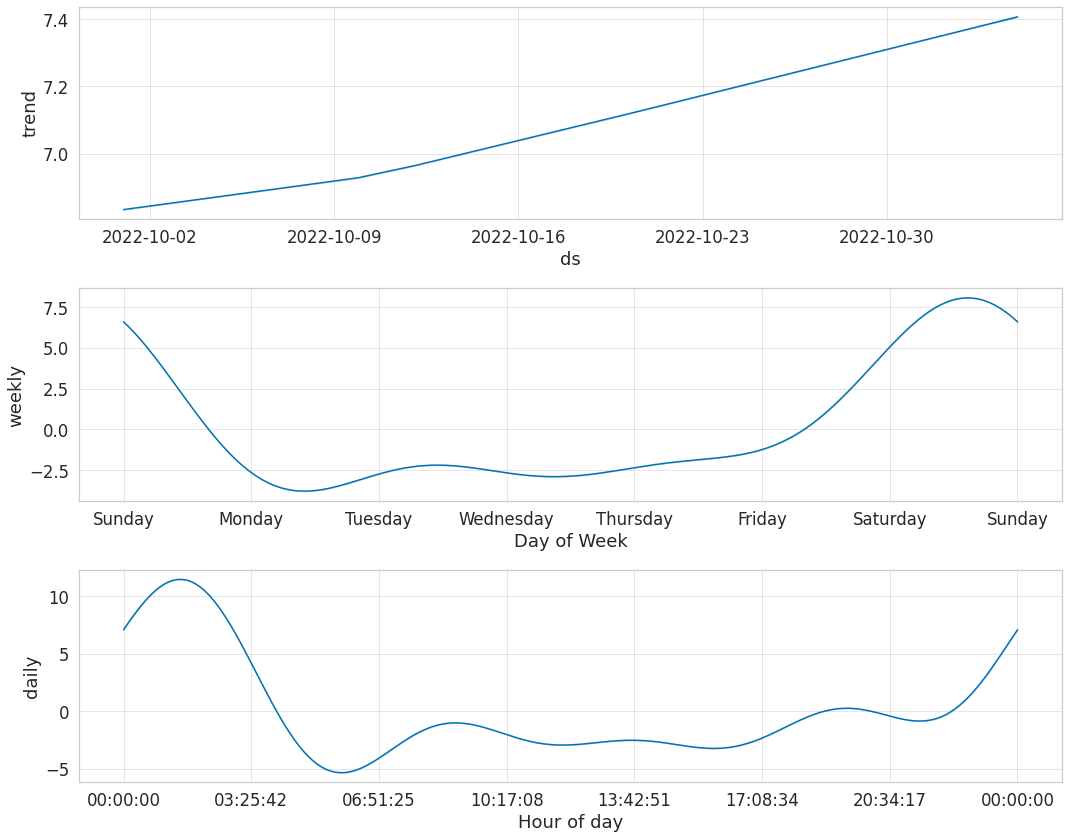

In [108]:
# checking the forecasting components
plot_2 = model.plot_components(counts_forecast, figsize=(15,12))